  **Sultan Arapov**

**BRIEF comparison of LGBM vs. Logistic regression model performances in predicting credit risk probability**

 **Metric chosen is Roc_auc**

In [76]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
pd.options.mode.chained_assignment = None

train = pd.read_excel("../input/Dataset.xlsx", 'train')
test = pd.read_excel("../input/Dataset.xlsx", 'test')
train.head()

,NUM,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,...,F91,F92,F93,F94,F95,F96,F97,F98,F99,F100,F101,F102,F103,F104,F105,F106,F107,F108,F109,F110,F111,F112,F113,F114,F115,F116,F117,F118,F119,F120,F121,F122,F123,F124,F125,F126,F127,F128,F129,TARGET
0,0,0.0,1.0,1.0,199900.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,49725.0,5.0,1.0,120.0,0.0,1.0,0.0,0.0,0.0,0.0,276677.278857,0.0,0.0,1.0,34.0,5.000000,1.0,660000.0,34.0,6.000000,0.0,0.0,0.0,0.0,1.0,1.0,220275.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.00000,0.0,0.0,0.0,1.0,0.783327,1.0,3.0,169970.000000,1.000000,1.0,1.0,1.0,0.0,170000.0,2.0,СТЕПЕНЬ,8.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2121.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,17.0,1.0,142918.000000,0.0,3.0,3.0,111.0,5.000000,0.0,125000.0,32.0,876.000000,5.0,0.0,3.0,3.0,19.0,0.0,92879.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,81883.51675,1.0,1.0,1.0,0.0,0.000000,1.0,1.0,424951.475678,2.430397,0.0,0.0,0.0,0.0,30000.0,2.0,СТЕПЕНЬ,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,2121.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,4.0,4.0,276677.278857,0.0,0.0,1.0,5.0,4.430142,0.0,120005.0,23.0,499.315904,0.0,0.0,0.0,0.0,0.0,0.0,-2120.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,81883.51675,0.0,1.0,1.0,0.0,0.000000,1.0,3.0,74129.000000,1.000000,1.0,1.0,0.0,0.0,4.0,6.0,СПЕЦ,5.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3,3,2.0,10.0,1.0,1187750.0,130990.0,6.0,0.0,2.0,0.0,0.0,0.0,0.0,2121.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0,5.0,5.0,276677.278857,0.0,0.0,6.0,6.0,4.430142,0.0,144500.0,21.0,88.000000,1.0,0.0,1.0,0.0,45.0,29.0,62879.0,...,0.0,1.0,3.0,4.0,1.0,3.0,0.0,0.0,0.0,1.0,11.0,1.0,12.0,130.00000,7.0,0.0,0.0,0.0,0.000000,1.0,3.0,350916.000000,6.000000,1.0,1.0,1.0,0.0,3000.0,2.0,СТЕПЕНЬ,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0
4,4,0.0,5.0,4.0,318771.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,57831.0,5.0,1.0,179.0,0.0,1.0,0.0,0.0,6.0,6.0,156218.000000,0.0,1.0,6.0,10.0,4.430142,0.0,125000.0,24.0,32.000000,0.0,0.0,0.0,0.0,1.0,7.0,27169.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.00000,0.0,0.0,0.0,1.0,1.000000,1.0,2.0,303138.000000,5.000000,1.0,1.0,1.0,0.0,40000.0,6.0,СТЕПЕНЬ,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [77]:
# There is a class imbalance with the ratio
train.TARGET.value_counts()[0]/train.TARGET.value_counts()[1]

1.8055737398297953

In [78]:
print('train.shape: {}'.format(train.shape))
print('test.shape: {}'.format(test.shape))

train.shape: (30000, 132)
test.shape: (10000, 131)


In [79]:
table = pd.concat([train.iloc[:,:130], test.iloc[:,:130]], axis=0)
table.set_index('NUM', inplace=True)
inputs = list(table.columns)
cat_vars = ['F120']

In [80]:
# Features that contain missing values
table.isnull().sum()[table.isnull().sum()>0]

F12     6873
F15    20822
F75    17648
dtype: int64

As the amount of missing values is pretty large for the given features, we will replace them by a rare value.

We assume that missing values appear not by chance, but rather for a reason, as they occurr only among these three features
and thus, might characterize borrowers in a certain way.

In [81]:
table.fillna(-999, inplace=True)

In [82]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(table['F120'])
print(list(le.classes_))

['ВЫСШ', 'НЕОК ВЫСШ', 'НЕТ', 'ПРОФИЛЬ', 'СПЕЦ', 'СРЕДН', 'СРЕПЕНЬ', 'СТЕПЕНЬ', 'ШКОЛ']


In [83]:
table['F120'] = le.transform(table['F120'])
table['F120'].head()

NUM
0    7
1    7
2    4
3    7
4    7
Name: F120, dtype: int64

In [84]:
training = table[:30000]
testing = table[30000:40000]

# **Logistic Regression**

In [85]:
# Features "l2" normalization for Logistic Regression model
from sklearn.preprocessing import normalize
norm = normalize(training[inputs], 'l2') 

norm = pd.DataFrame(norm, index=training.index, columns=training[inputs].columns)
norm = pd.concat([norm, train['TARGET']], axis=1)

In [89]:
# Model estimation using stratified k-fold validation approach
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(class_weight='balanced')
y = train['TARGET']
scores = cross_val_score(log_reg, norm[inputs], y, cv=5, scoring='roc_auc')
print(scores)
print(scores.mean())

[0.79843279 0.80021518 0.80411661 0.79062458 0.79121926]
0.7969216866532195


**As almost all the features carry no useful information in either their names or values, the feature selection/engineering procedure
will be restricted to being applied a greedy algorithm of recursive feature elimination**

Optimal number of features : 21


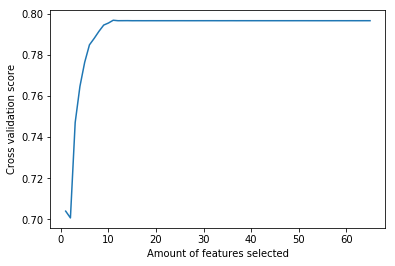

Score: 0.7967900350334263 


In [90]:
# Model estimation using Recursive Feature Elimination and stratified k-fold validation approach
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

log_reg = LogisticRegression()
rfecv = RFECV(estimator=log_reg, step=2, cv=StratifiedKFold(5),
              scoring='roc_auc')
rfecv.fit(norm[inputs], y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plotting number of features vs. cross-validation "roc_auc" scores
plt.figure()
plt.xlabel("Amount of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show() 
print('Score: {} '.format(rfecv.grid_scores_.max()))

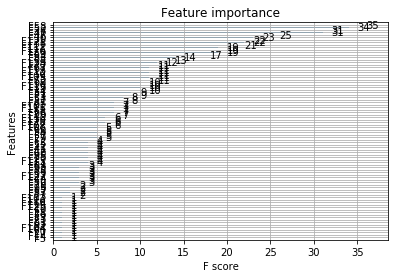

In [91]:
# A bit of visualization on feature importance using XGBoost function
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(training[inputs], y)
# plot feature importance
plot_importance(model)
pyplot.show()

# print(model.feature_importances_)

# **LGBM**

In [92]:
# For LGBM we will neither normalize features nor select or generate specific features
data = pd.concat([training, y], axis=1)
training = data.sample(30000)
holdout = training[:5000]
main = training[5000:]
target = main['TARGET']

metrics = 'auc'
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': metrics,
    'learning_rate': .1,
    'num_leaves': 7,
#   'max_depth': 4,
#   'min_child_samples': 100,
#   'max_bin': 100,
#   'subsample': 0.7,
    'subsample_freq': 1,
#   'colsample_bytree': 0.7,
    'min_child_weight': 0,
    'min_split_gain': 0,
    'nthread': 4,
    'verbose': 1,
    'scale_pos_weight': 1.8
}

num_boost_round=30

from sklearn.model_selection import train_test_split
train_df, val_df, y_train, y_val = train_test_split(main, target, train_size=.8, shuffle=False, random_state=42)
xgtrain = lgb.Dataset(train_df[inputs].values, label=y_train,
              feature_name=inputs,
              categorical_feature=cat_vars)


xgvalid = lgb.Dataset(val_df[inputs].values, label=y_val,
              feature_name=inputs,
              categorical_feature=cat_vars)
# gc.collect()

evals_results = {}
early_stopping_rounds = 5

model = lgb.train(lgb_params,
          xgtrain,
          valid_sets= [xgvalid],
          valid_names=['valid'],
          evals_result=evals_results,
          num_boost_round=num_boost_round,
#         early_stopping_rounds=early_stopping_rounds,
          verbose_eval=1,
          feval=None)
n_estimators = model.best_iteration

print('\nModel Info:')
print('n_estimators:', n_estimators)
print(metrics+':', evals_results['valid'][metrics][n_estimators-1])

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2022: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid's auc: 0.807307
[2]	valid's auc: 0.840051
[3]	valid's auc: 0.864827
[4]	valid's auc: 0.872037
[5]	valid's auc: 0.875638
[6]	valid's auc: 0.883127
[7]	valid's auc: 0.891525
[8]	valid's auc: 0.895804
[9]	valid's auc: 0.900505
[10]	valid's auc: 0.903403
[11]	valid's auc: 0.905493
[12]	valid's auc: 0.906952
[13]	valid's auc: 0.909252
[14]	valid's auc: 0.910919
[15]	valid's auc: 0.913608
[16]	valid's auc: 0.915749
[17]	valid's auc: 0.916235
[18]	valid's auc: 0.917894
[19]	valid's auc: 0.918734
[20]	valid's auc: 0.919832
[21]	valid's auc: 0.920717
[22]	valid's auc: 0.921562
[23]	valid's auc: 0.923274
[24]	valid's auc: 0.924924
[25]	valid's auc: 0.925346
[26]	valid's auc: 0.92603
[27]	valid's auc: 0.926447
[28]	valid's auc: 0.92719
[29]	valid's auc: 0.927991
[30]	valid's auc: 0.928898

Model Info:
n_estimators: 0
auc: 0.928897939205127


In [93]:
# model evaluation on the holdout set
y_scores = model.predict(holdout[inputs])
y_true = holdout['TARGET']
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_scores)

0.9223276919162646

**It is obvious that ligtgbm model showed much better roc_auc than logistic regression model**

In [94]:
# train = lgb.Dataset(training[inputs].values, label=y,
#       feature_name=inputs)
# num_round = 20
# lgb.cv(lgb_params, train,  num_round, nfold=10)

In [95]:
# Predicting test set
pred = pd.DataFrame()
pred['TARGET'] = model.predict(testing[inputs], num_iteration=n_estimators)
pred.to_csv('predicted.csv', index=False)